В качестве домашнего задания вам предлагается поработать над предсказанием погоды. Файл с данными вы найдете в соответствующей директории. Вам будет доступен датасет weather.csv, ПЕРВЫЕ 75% (shuffle = False) которого нужно взять для обучения, последние 25% - для тестирования.

Требуется построить 4 модели которые будут предсказывать целевую переменную <b>RainTomorrow</b> с помощью:

   1. логистической регрессии [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
   
   2. метода ближайших соседей [sklearn.neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
 
   3. Байесовского классификатора [sklearn.naive_bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
   
   4. логистической регрессии реализованной самостоятельно

Затем следует сравнить результаты моделей (по качеству и времени выполнения) и сделать вывод о том, какая модель и с какими параметрами даёт лучшие результаты.

Не забывайте о том, что работа с признаками играет очень большую роль в построении хорошей модели.

Краткое описание данных:

    Date - Дата наблюдений
    Location - Название локации, в которой расположена метеорологическая станция
    MinTemp - Минимальная температура в градусах цельсия
    MaxTemp - Максимальная температура в градусах цельсия
    Rainfall - Количество осадков, зафиксированных за день в мм
    Evaporation - Так называемое "pan evaporation" класса А (мм) за 24 часа до 9 утра
    Sunshine - Число солнечных часов за день
    WindGustDir - направление самого сильного порыва ветра за последние 24 часа
    WindGustSpeed - скорость (км / ч) самого сильного порыва ветра за последние 24 часа
    WindDir9am - направление ветра в 9 утра

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn import preprocessing
%matplotlib notebook

sns.set(style="darkgrid")

0. Предобработка данных

In [2]:
from datetime import datetime
from datetime import date

In [3]:
def date_transformer(date_str):
    t = datetime.strptime(date_str, "%Y-%m-%d").date()
    return (t - date(t.year, 1, 1)).days

In [4]:
date_transformer('2000-2-1')

31

In [7]:
from datetime import datetime
from sklearn.model_selection import train_test_split

X = pd.read_csv('./data/weather.csv')
y = X['RainTomorrow'].replace({'No':0, 'Yes': 1})
del X['RainTomorrow']
del X['Unnamed: 0']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10, shuffle = False)

X_train.RainToday = X_train['RainToday'].replace({'No':0, 'Yes': 1})
X_test.RainToday = X_test['RainToday'].replace({'No':0, 'Yes': 1})

date_transformer_vec = np.vectorize(date_transformer) # Преобразую дату в число дней с начала года
X_train.Date = pd.Series(date_transformer_vec(X_train.Date))
X_test.Date = pd.Series(date_transformer_vec(X_test.Date))

categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

numeric_data = X_train.select_dtypes([np.number])

numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

X_train.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Date,335,336,337,338,339,340,341,342,343,344,345,346,347,348,350,351,352,353,354,355
Location,Albury,Albury,Albury,Albury,Albury,Albury,Albury,Albury,Albury,Albury,Albury,Albury,Albury,Albury,Albury,Albury,Albury,Albury,Albury,Albury
MinTemp,13.4,7.4,12.9,9.2,17.5,14.6,14.3,7.7,9.7,13.1,13.4,15.9,15.9,12.6,9.8,14.1,13.5,11.2,9.8,11.5
MaxTemp,22.9,25.1,25.7,28.0,32.3,29.7,25.0,26.7,31.9,30.1,30.4,21.7,18.6,21.0,27.7,20.9,22.9,22.5,25.6,29.3
Rainfall,0.6,0.0,0.0,0.0,1.0,0.2,0.0,0.0,0.0,1.4,0.0,2.2,15.6,3.6,2.411648,0.0,16.8,10.6,0.0,0.0
Evaporation,5.339228,5.339228,5.339228,5.339228,5.339228,5.339228,5.339228,5.339228,5.339228,5.339228,5.339228,5.339228,5.339228,5.339228,5.339228,5.339228,5.339228,5.339228,5.339228,5.339228
Sunshine,7.382788,7.382788,7.382788,7.382788,7.382788,7.382788,7.382788,7.382788,7.382788,7.382788,7.382788,7.382788,7.382788,7.382788,7.382788,7.382788,7.382788,7.382788,7.382788,7.382788
WindGustDir,W,WNW,WSW,NE,W,WNW,W,W,NNW,W,N,NNE,W,SW,WNW,ENE,W,SSE,SSE,S
WindGustSpeed,44.0,44.0,46.0,24.0,41.0,56.0,50.0,35.0,80.0,28.0,30.0,31.0,61.0,44.0,50.0,22.0,63.0,43.0,26.0,24.0
WindDir9am,W,NNW,W,SE,ENE,W,SW,SSE,SE,S,SSE,NE,NNW,W,NotGiven,SSW,N,WSW,SE,SE


1. LogisticRegression

In [527]:
%%timeit

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

1.76 s ± 139 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [524]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     27882
           1       0.74      0.47      0.57      7667

    accuracy                           0.85     35549
   macro avg       0.80      0.71      0.74     35549
weighted avg       0.84      0.85      0.84     35549



In [530]:
%%timeit

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', preprocessing.MinMaxScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

1.92 s ± 298 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [529]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     27882
           1       0.74      0.48      0.58      7667

    accuracy                           0.85     35549
   macro avg       0.81      0.72      0.75     35549
weighted avg       0.84      0.85      0.84     35549



 => MinMaxScaler ненамного тут лучше, чем StandardScaler

In [536]:
%%timeit

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', preprocessing.MinMaxScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(penalty = 'l2', solver = 'saga'))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

9.55 s ± 665 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [535]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     27882
           1       0.72      0.52      0.61      7667

    accuracy                           0.85     35549
   macro avg       0.80      0.73      0.76     35549
weighted avg       0.84      0.85      0.84     35549



Тут использовал solver 'saga' с L2, потому что он выдавал самую лучшую точность (хоть и сильно проигрывает в скорости)

2. KNeighborsClassifier


  0%|          | 0/25 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


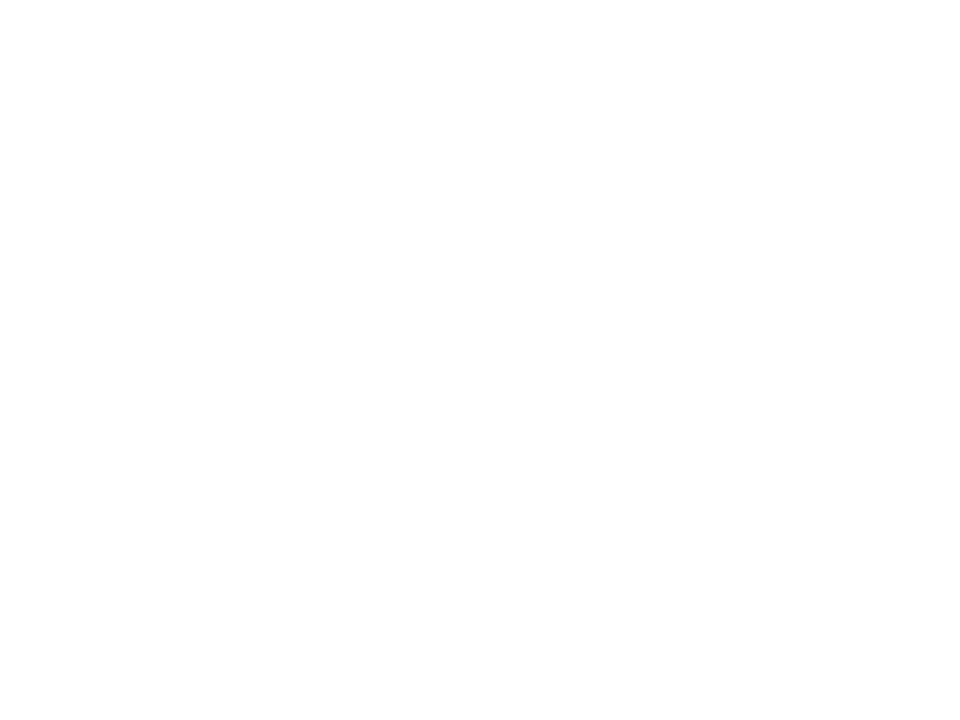

In [484]:
from tqdm import tqdm_notebook
from sklearn.neighbors import KNeighborsClassifier

accuracy = []
for n in tqdm_notebook(range(1, 50, 2)):
    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
        ('scaling', preprocessing.MinMaxScaler(), numeric_features)
    ])

    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', KNeighborsClassifier(n_neighbors=n))
    ])

    model = pipeline.fit(X_train, y_train)
    accuracy.append( np.mean(model.predict(X_test) == y_test)) 
    
plt.plot(range(1, 50, 2), accuracy)

<IPython.core.display.Javascript object>


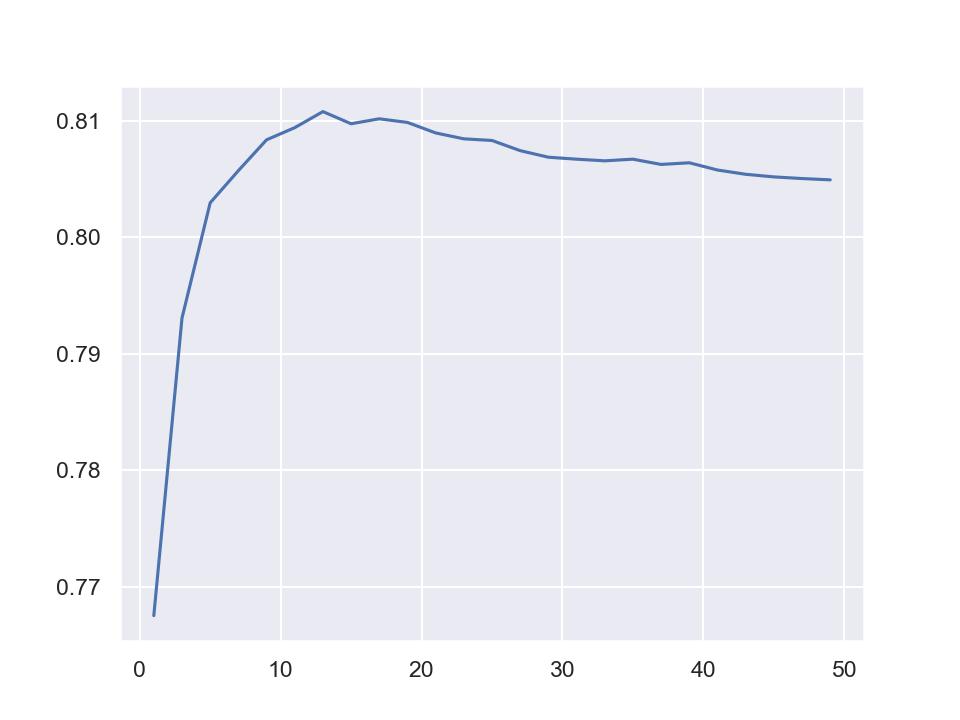

Optimal number of neighbors:  13


In [495]:
plt.plot(range(1, 50, 2), accuracy)
print("Optimal number of neighbors: ", 2*accuracy.index(max(accuracy)) + 1)

In [550]:
%%timeit

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', preprocessing.MinMaxScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('kneighborsClassifier', KNeighborsClassifier(n_neighbors=13))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

5min 14s ± 4.34 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [549]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89     27882
           1       0.67      0.24      0.36      7667

    accuracy                           0.81     35549
   macro avg       0.75      0.60      0.62     35549
weighted avg       0.79      0.81      0.77     35549



//Я, очевидно, тут что-то не так сделал, потому что качество модели ужасно, так ещё и считается миллион лет.

3. Байессовым классификатором

In [576]:
%%timeit

from sklearn.naive_bayes import MultinomialNB

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', preprocessing.MinMaxScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('MultinomialNB ', MultinomialNB())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

424 ms ± 80.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [575]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.97      0.89     27882
           1       0.66      0.18      0.29      7667

    accuracy                           0.80     35549
   macro avg       0.74      0.58      0.59     35549
weighted avg       0.78      0.80      0.76     35549



In [577]:
%%timeit

from sklearn.naive_bayes import ComplementNB

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', preprocessing.MinMaxScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('ComplementNB ', ComplementNB())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

497 ms ± 87.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [573]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.71      0.80     27882
           1       0.42      0.76      0.54      7667

    accuracy                           0.72     35549
   macro avg       0.67      0.74      0.67     35549
weighted avg       0.81      0.72      0.74     35549



In [564]:
%%timeit

from sklearn.naive_bayes import BernoulliNB

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('BernoulliNB', BernoulliNB())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

528 ms ± 105 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [563]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88     27882
           1       0.58      0.60      0.59      7667

    accuracy                           0.82     35549
   macro avg       0.73      0.74      0.74     35549
weighted avg       0.82      0.82      0.82     35549



=> Сравнил Бернулли, ComplementNB и MultinomialNB, тут лучше сработал BernoulliNB, потому что хорошо подходит под задачу

4. Собственная реализация логистической регрессии

### Реализация логистической регрессии
__Логистическая регрессия__

$$p(y|x) = a(x, \theta) = \sigma(\langle x, \theta \rangle) = \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}$$

In [660]:
theta = np.array([1, 2, 3])

X =  np.array([[ 1,  1, 1],
               [-1, -2, 1],
               [-1, -2, 2],
               [-2, -2, -3]
              ])

y = np.array([1, 1, 0, 0])

In [661]:
import math

def probability(theta, X):
    result = np.array([])
    for i in np.arange(X.shape[0]):
        result = np.append(result, 1/(1 + math.exp(-(X[i]*theta).sum())))
    return result
prob = probability(theta, X)


assert type(prob) == np.ndarray, 'Возвращается неверный тип'
assert prob.shape == (X.shape[0],), 'Неверный размер массива'
assert (prob.round(3) == [0.998, 0.119, 0.731, 0.]).all(), 'Функция считается неверно'
print(prob)

[9.97527377e-01 1.19202922e-01 7.31058579e-01 3.05902227e-07]


Функция предсказания метки класса, получает на вход вероятности принадлежности к классу 1 и выдает метки классов $y \in \{0, 1\}$

In [662]:
def binary_class_prediction(theta, X, threshold =.5):
    prob =  probability(theta, X)
    result = (prob > threshold) * 1
    return result

y_pred = binary_class_prediction(theta, X)


assert type(y_pred) == np.ndarray, 'Возвращается неверный тип'
assert y_pred.shape == (X.shape[0],), 'Неверный размер массива'
assert min(y_pred) == 0, 'Функция считается неверно'
assert max(y_pred) == 1, 'Функция считается неверно'
print(y_pred)

[1 0 1 0]


__Функционал качества логистической регрессии__

Запишем правдободовие выборки для меток класса $y \in \{+1, -1\}$ 

$$Likelihood(a, X^\ell) = \prod_{i = 1}^{\ell} a(x_i,\theta)^{[y_i = +1]} (1 - a(x_i, \theta))^{[y_i = -1]} → \operatorname*{max}_{\theta}$$ 

Прологарифмируем правдоподобие выборки и перейдем к задаче минимизации:

$$Q(a, X^\ell) =     -\sum_{i = 1}^{\ell} 
        [y_i = +1] \log a(x_i, \theta)
        +
        [y_i = -1] \log (1 - a(x_i, \theta)) \to \operatorname*{min}_{\theta}$$ 
        
Подставим $a(x, \theta)$ в функцинал качества:

$$ Q(a, X^\ell) = -\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{\exp(-\langle \theta, x_i \rangle)}{1 + \exp(-\langle \theta, x_i \rangle)}
\right)
=\\
=
-\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{1}{1 + \exp(\langle \theta, x_i \rangle)}
\right)
=\\
=
\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) $$
    

Итоговый оптимизируемый функционал качества (logloss), записанный для меток классов $y \in \{+1, -1\}$ и усредненный по выборке

$$Q(a, X^\ell) = \frac{1}{\ell}\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) \to \operatorname*{min}_{\theta}$$

Реализуем его в функции logloss:

In [663]:
import math
def logloss(theta, X, y):
    y += (y == 0) * (-1) # просто переобозначение меток 
    sum_of_logs = 0
    l, _ = X.shape
    for i in np.arange(l):
        sum_of_logs += math.log(1 + math.exp(-y[i]*(X[i]*theta).sum()))
    result = np.array(sum_of_logs / l)
    return result

In [664]:
assert logloss(theta, X, y).round(3) == 0.861, 'Функция считается неверно'

__Алгоритм оптимизации функционала качества. Стохастический градиентный спуск__

<b>Вход: </b> Выборка $X^\ell$, темп обучения $h$

<b>Выход: </b> оптимальный вектор весов $\theta$

1.  Инициализировать веса $\theta$
2.  Инициализировать оценку функционала качества: $Q(a, X^\ell)$
3.  <b>Повторять</b>: 

    Выбрать случайным образом подвыборку объектов $X^{batch} =\{x_1, \dots,x_n \}$ из $X^{\ell}$
    
    Рассчитать градиент функционала качества: $\nabla Q(X^{batch}, \theta)$
    
    Обновить веса: $\theta := \theta - h\cdot \nabla Q(X^{batch}, \theta)$
       
    <b>Пока</b> значение $Q$ и/или веса $\theta$ не сойдутся   

Реализуем функцию рассчета градиента функционала качества

$$\frac{\partial Q(a, X^{batch}) }{\partial \theta_j}   = \frac{\partial \frac{1}{n}\sum_{i = 1}^{n}
    \log \left(
        1 + \exp(- y_i \langle \theta, x_i \rangle)
    \right)} {\partial \theta_j}  = \frac{1}{n}\sum_{i = 1}^{n}
     \frac {1}{
        1 + \exp(- y_i \langle \theta, x_i \rangle)} \cdot  \exp(- y_i \langle \theta, x_i \rangle) \cdot -y_i x_{ij}$$

Реализуйте рассчет градиента в матричном виде:

In [666]:
import math

def gradient(theta, X, y):
    y += (y == 0) * (-1) # просто переобозначение меток 
    n, columns = X.shape
    result = np.array([])
#     print(y.values)
    for j in np.arange(columns):
        sum_of_column = 0
        for i in np.arange(n):
            sum_of_column += (math.exp(-y[i]*(X[i]*theta).sum()) * (-y[i]*X[i, j]) 
                             / (1+math.exp(-y[i]*(X[i]*theta).sum())))
        result = np.append(result, sum_of_column / n)
            
    return result 

assert gradient(theta, X, y).shape == theta.shape, 'Неверный размер массива'
print(gradient(theta, X, y))

[0.03681632 0.07425094 0.14471163]


Функция обучения уже реализована

In [759]:
def fit(X, y, batch_size=150, h=0.05,  iters=100, plot=True):

    # получаем размерности матрицы
    size, dim = X.shape

    # случайная начальная инициализация
    theta = np.random.uniform(size=dim)
    
    errors = []
    
    theta_history = theta
    colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]
    
    # plt 
    if plot:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Gradient descent')
        
        
    for _ in range(iters):  
        
        # берём случайный набор элементов
        batch = np.random.choice(size, batch_size, replace=False)
        X_batch = X[batch]
        y_batch = y[batch]

        # считаем производные
        grad = gradient(theta, X_batch, y_batch)
        
        assert type(grad) == np.ndarray, 'неверный тип'
        assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
        assert grad.shape[0] == len(theta), 'длина вектора должна быть равной количеству весов'
        
        
        # Обновляем веса
        
        theta -= grad * h
        
        theta_history = np.vstack((theta_history, theta))
        
        # error
        loss = logloss(theta, X, y)
        errors.append(loss)
        
        if plot:
            ax1.clear()            
            ax1.scatter(range(dim), theta, label='Gradient solution')
            ax1.legend(loc="upper left")
            ax1.set_title('theta')
            ax1.set_ylabel(r'$\bar \beta$')
            ax1.set_xlabel('weight ID')
            
            
            ax2.plot(range(_+1), errors, 'g-')
            ax2.set_title('logloss')
            ax2.set_xlabel('itarations')
            
            ax3.plot(theta_history)
            ax3.set_title('update theta')
            ax3.set_ylabel('value')
            ax3.set_xlabel('itarations')
#             time.sleep(0.05)  # Чтобы быстрее рисовалось просто
            fig.canvas.draw()   
            
    return theta

In [668]:
X, y = make_classification(n_samples=2000)

In [542]:
%%timeit
optimal_theta = fit(X, y, plot = False)

2.09 s ± 137 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<IPython.core.display.Javascript object>


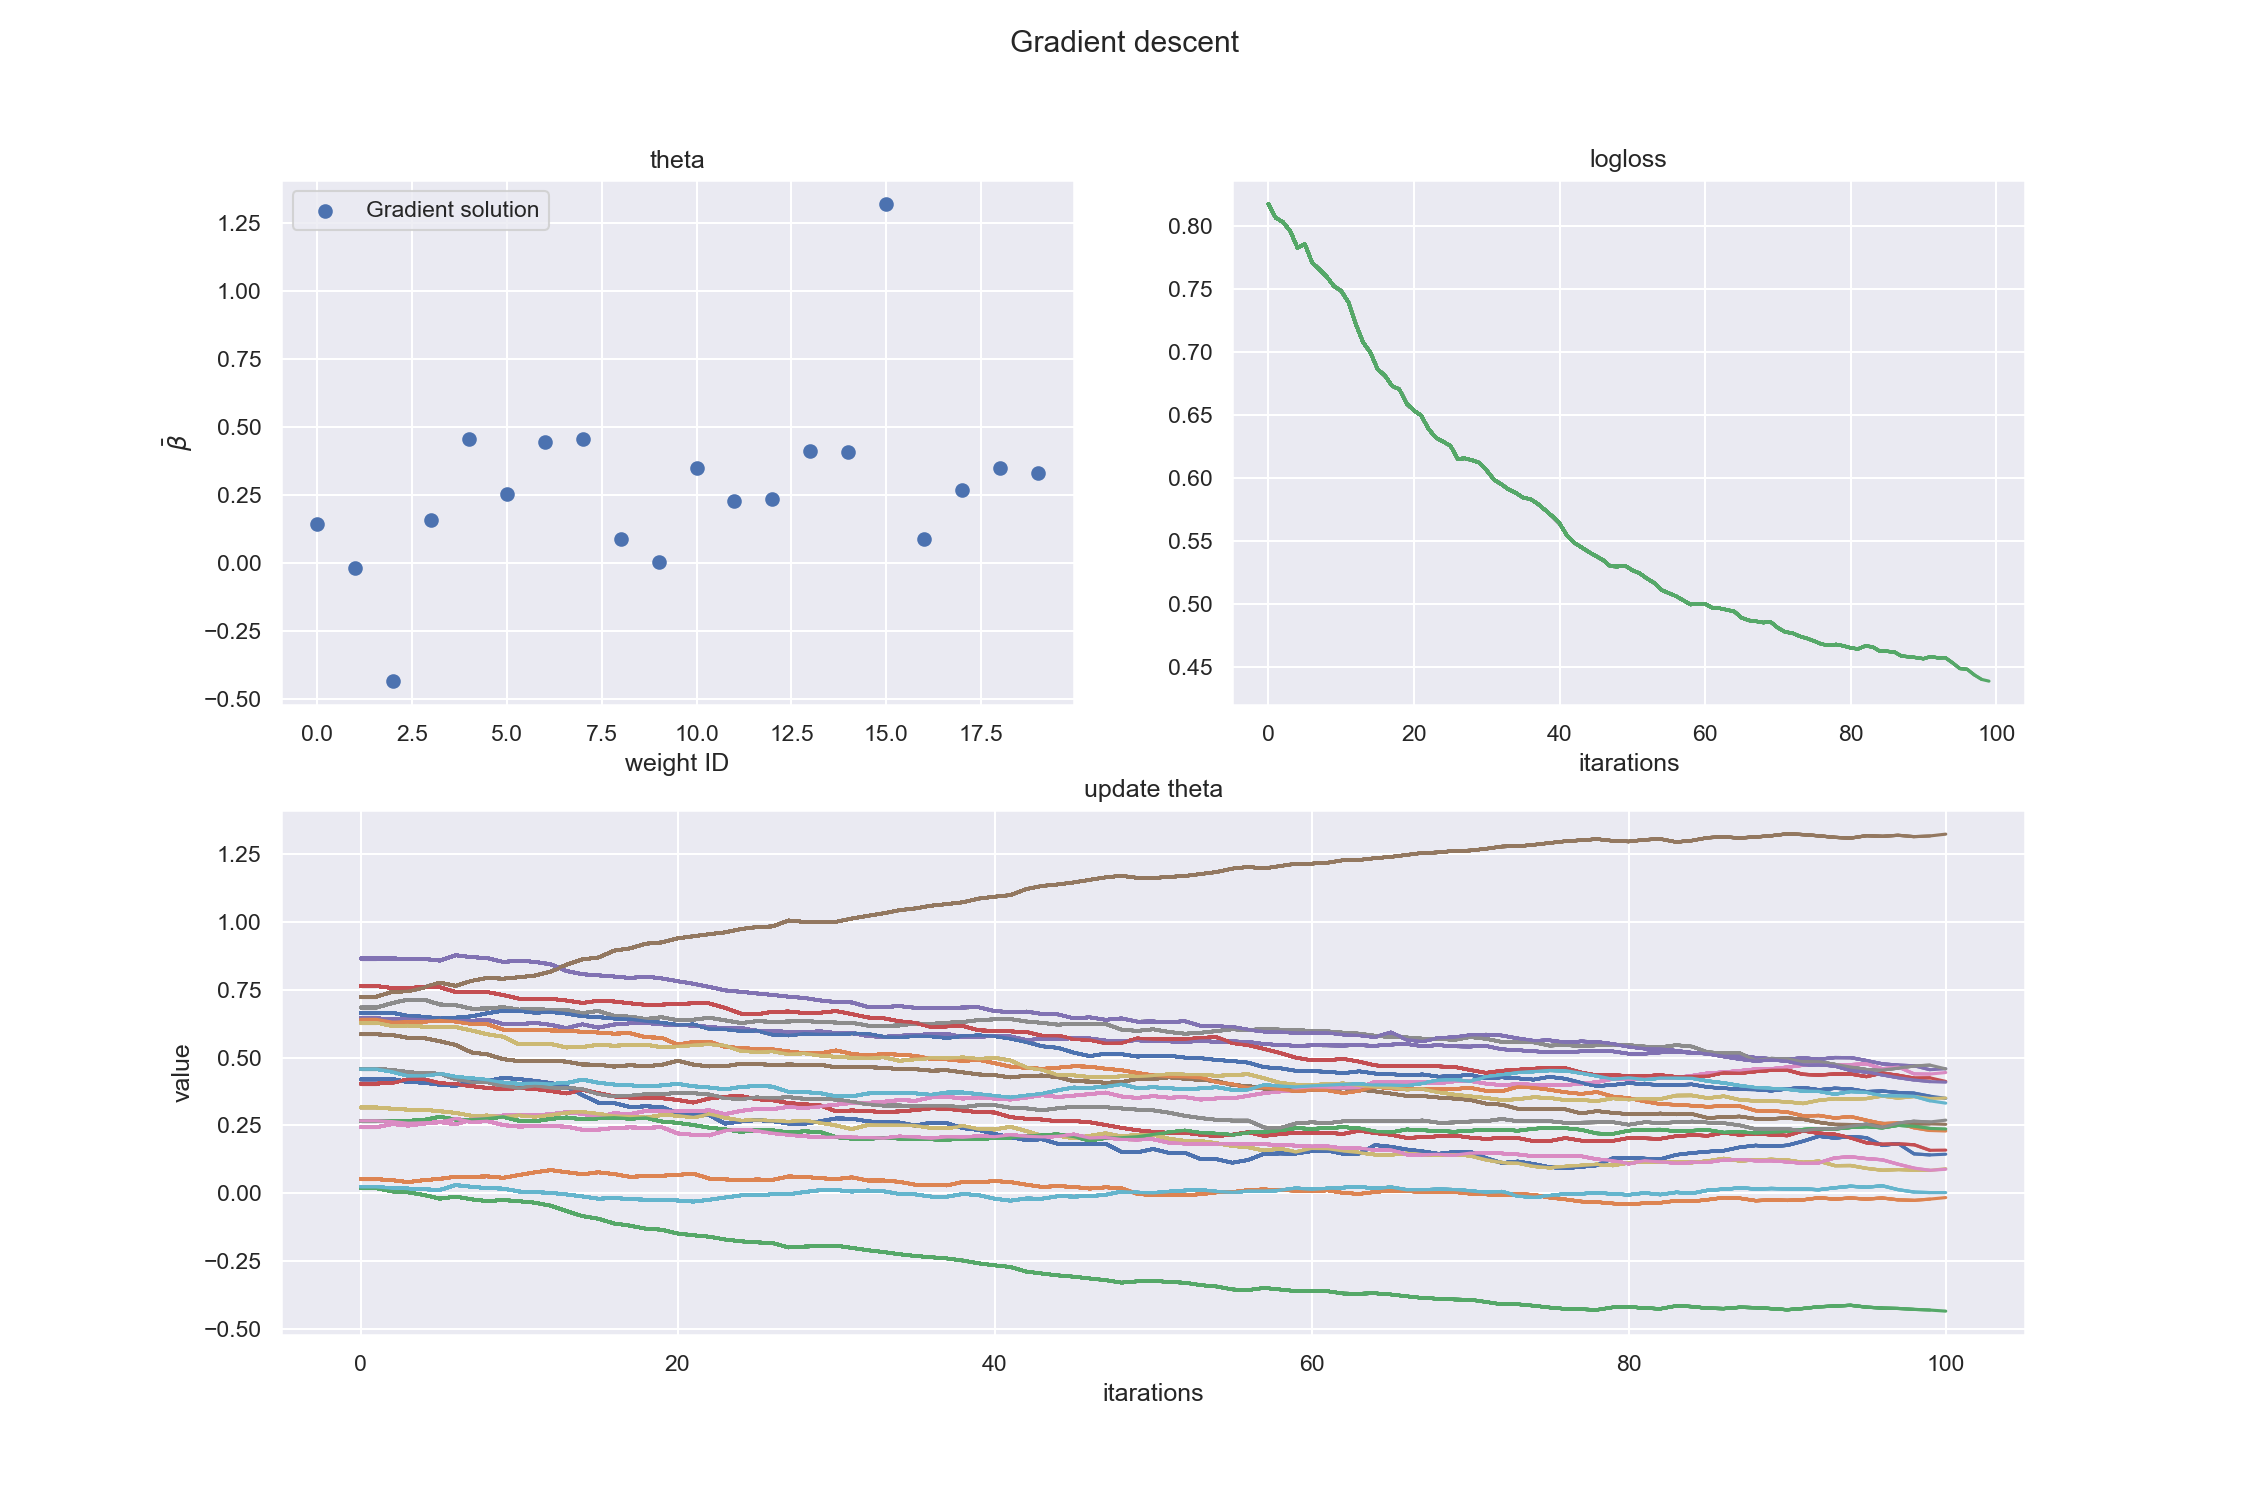

In [669]:
optimal_theta = fit(X, y, plot = True)

In [670]:
y_pred = binary_class_prediction(optimal_theta, X)

In [671]:
from sklearn.metrics import classification_report

y_pred += (y_pred == 0) * (-1) # просто переобозначение меток 
print(classification_report(y_pred, y))

              precision    recall  f1-score   support

          -1       0.81      0.79      0.80      1026
           1       0.78      0.81      0.80       974

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80      0.80      0.80      2000



<IPython.core.display.Javascript object>


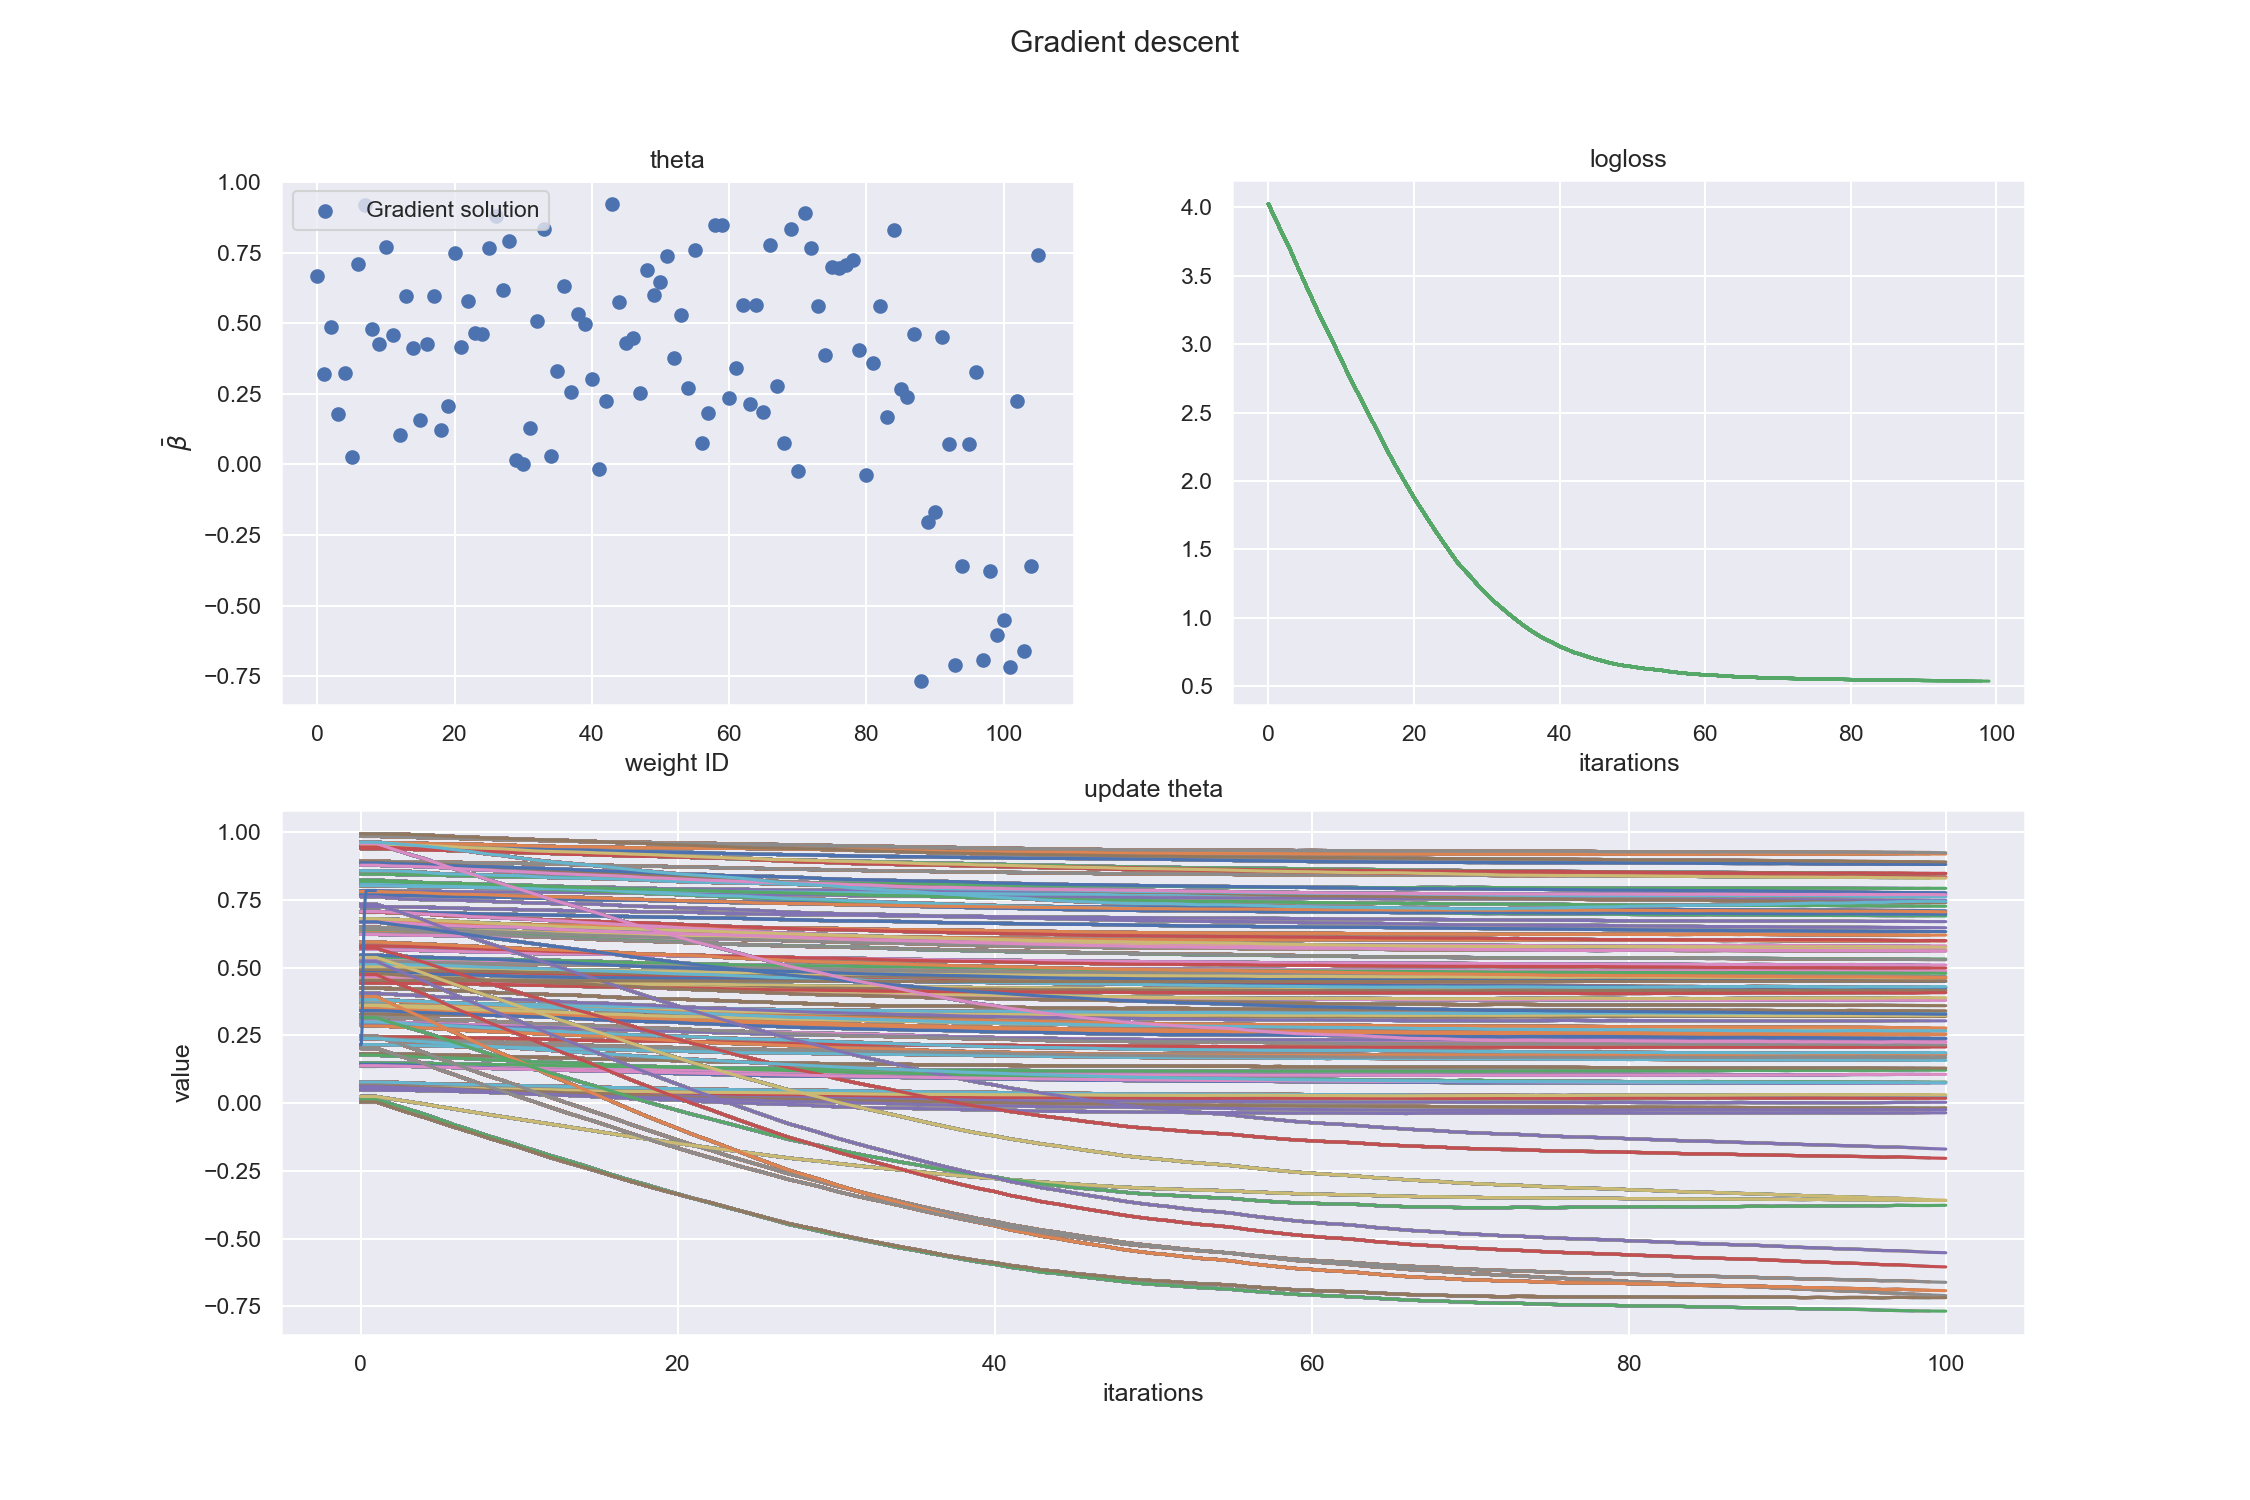

In [760]:
X = pd.read_csv('weather.csv')
y = X['RainTomorrow'].replace({'No':0, 'Yes': 1})
del X['RainTomorrow']
del X['Unnamed: 0']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10, shuffle = False)

X_train.RainToday = X_train['RainToday'].replace({'No':0, 'Yes': 1})
X_test.RainToday = X_test['RainToday'].replace({'No':0, 'Yes': 1})

date_transformer_vec = np.vectorize(date_transformer) # Преобразую дату в число дней с начала года
X_train.Date = pd.Series(date_transformer_vec(X_train.Date))
X_test.Date = pd.Series(date_transformer_vec(X_test.Date))

categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

numeric_data = X_train.select_dtypes([np.number])

numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', preprocessing.MinMaxScaler(), numeric_features)
])

X_test = column_transformer.fit(X_train).transform(X_test)
X_train = column_transformer.fit_transform(X_train)

X_temp = X_train.toarray()
y_temp = y_train.to_numpy()
optimal_theta_weather = fit(X_temp, y_temp, plot = True)

In [761]:
accuracy = []
for n in tqdm_notebook(np.arange(0, 1, 0.05)):
    y_pred = binary_class_prediction(optimal_theta_weather, X_test, n)
    accuracy.append( np.mean(y_pred == y_test)) 
plt.plot(np.arange(0, 1, 0.05), accuracy)
print("Optimal threshhold: ", accuracy.index(max(accuracy))*0.05)

  0%|          | 0/20 [00:00<?, ?it/s]

Optimal threshhold:  0.45


In [762]:
optimal_threshold = accuracy.index(max(accuracy))*0.05
print(classification_report(binary_class_prediction(optimal_theta_weather, X_test, optimal_threshold), y_test))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88     35055
           1       0.03      0.51      0.06       494

    accuracy                           0.78     35549
   macro avg       0.51      0.65      0.47     35549
weighted avg       0.98      0.78      0.87     35549



<b>Вывод</b>: в ходе работы я рассмотрел 4 модели, сравнил их точности и скорости работы. У Байесовых классификаторов самое лучшее время, но страдает точность, а логистической регрессией медленнее, зато лучше точность.

<b>В итоге</b>: лучше всего на этом датасете лучше всего себя показала модель логистической регресии с solver 'saga', регуляризацией L2 и предобработкой данных OneHotEncoder и MinMaxScaler.